# The main idea

Basically the idea would be to simply analyze the data and portray it through interactive graphs on a website. Ideally the website would be updated daily. 

This way all community members can see what the "mayor sees". 

If a community has an unusual number of complaints, they should be able to see for themselves that their situation is in fact unusual and that they have a right to be angry. Transparency is the main point.

As for the techniques involved. In the short time that we've actually worked on it (after losing most of the hackathon time deliberating on what project we should do...) we basically focused on the top 3 complaints. 
1.Plotted them on a heatmap
2.Combined the 311 complaint database with weather data
3.Did an elasticNet regression to try to predict the number of complaints
4.Took at quick peak at the seasonality of the data. 

To be honest there was a lot of wasted time. Hackathons are like that. But I've got lots of other ideas as to what more we could do as well as machine learning techniques to make it easier for people to report in complaints. 

Anyways hope this helped and thank you for setting up this 311 dataset. 

Alex Keenan from the 311 A.I group.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 15)
%matplotlib inline
import numpy as np
from myscripts import *
import matplotlib


In [2]:
try:
    data=pd.read_csv("311complaints.csv",index_col="DDS_DATE_CREATION",parse_dates=True,encoding = "ISO-8859-1")
    print("used smaller csv")
except:
    data=pd.read_csv("311data.csv",index_col="DDS_DATE_CREATION",parse_dates=True)
    print("used LARGER csv")
    data=data[data.NATURE.values=="Plainte"]
    print(data.columns)
    data.sort_index(inplace=True);
    #saving smaller df for future reference
    data.to_csv("311complaints.csv")

used smaller csv


In [3]:
data.columns

Index(['ID_UNIQUE', 'NATURE', 'ACTI_NOM', 'TYPE_LIEU_INTERV', 'RUE',
       'RUE_INTERSECTION1', 'RUE_INTERSECTION2', 'LOC_ERREUR_GDT',
       'ARRONDISSEMENT', 'ARRONDISSEMENT_GEO', 'LIN_CODE_POSTAL',
       'PROVENANCE_ORIGINALE', 'PROVENANCE_TELEPHONE', 'PROVENANCE_COURRIEL',
       'PROVENANCE_PERSONNE', 'PROVENANCE_COURRIER', 'PROVENANCE_TELECOPIEUR',
       'PROVENANCE_INSTANCE', 'PROVENANCE_MOBILE', 'PROVENANCE_MEDIASOCIAUX',
       'PROVENANCE_SITEINTERNET', 'UNITE_RESP_PARENT', 'LOC_LONG', 'LOC_LAT',
       'LOC_X', 'LOC_Y'],
      dtype='object')

In [4]:
data.ACTI_NOM.value_counts()


Opération déneigement                                      2188
Collecte de déchets                                        1417
Collecte des matières recyclables                           725
Environnement - Divers                                      651
Voirie - Divers                                             622
Neige - Divers                                              622
Balai mécanique                                             349
Eau - Divers                                                328
Collecte de résidus alimentaires                            310
Sports et loisirs - Installations                           299
Élagage                                                     282
Maires et élus d'arrondissement                             280
Collecte de résidus verts                                   279
Services Techniques - Varia                                 275
Permis - Divers                                             254
Retour DDS                              

In [5]:

data_2016_over=data[data.index.year>=2016]
data_2015_over=data[data.index.year>=2015]
data_2014_over=data

In [6]:
#looking for how many datapoints have some information on their location
def data_with_location(data):
    data_with_location=pd.DataFrame()
    indexes_in_common=[]

    for each in ['LOC_LONG', 'LOC_LAT', 'LOC_X', 'LOC_Y','RUE','RUE_INTERSECTION1', 'RUE_INTERSECTION2','LIN_CODE_POSTAL','ARRONDISSEMENT','ARRONDISSEMENT_GEO']:
        not_null_data=data[data[each].notnull()]
        some_loc_data=not_null_data[not_null_data[each]!=0]
        if data_with_location.shape[0]==0:
            data_with_location=some_loc_data
        else:
            data_with_location=pd.concat([data_with_location,some_loc_data])
        data_with_location=data_with_location.groupby(data_with_location.index).first()
        
    return data_with_location

data_with_location2016=data_with_location(data_2016_over)
data_with_location2015=data_with_location(data_2015_over)
data_with_location2014=data_with_location(data_2014_over)
#data_with_location2014=data_with_location(data)

In [7]:
#Complaint data points have locations. Good!
pct_location=data_with_location2016.shape[0]/data_2016_over.shape[0]
print("percentage of data points 2016 and over with location = %0.3f"%pct_location)

pct_location=data_with_location2015.shape[0]/data_2015_over.shape[0]
print("percentage of data points 2015 and over with location = %0.3f"%pct_location)

pct_location=data_with_location2014.shape[0]/data_2014_over.shape[0]
print("percentage of data points 2014 and over with location = %0.3f"%pct_location)



percentage of data points 2016 and over with location = 0.999
percentage of data points 2015 and over with location = 1.000
percentage of data points 2014 and over with location = 1.000


In [8]:
data_with_location2016_complaint=data_with_location2016[data_with_location2016.NATURE.values=="Plainte"]
data_with_location2015_complaint=data_with_location2015[data_with_location2015.NATURE.values=="Plainte"]
data_with_location2014_complaint=data_with_location2014[data_with_location2014.NATURE.values=="Plainte"]

In [9]:
from myscripts import *
#"Opération déneigement" 
#"Collecte de déchets"
#"Collecte des matières recyclables"

def get_complaint_data(df,col_name,columns_needed=[]):
    temp_df=df[df.ACTI_NOM.values==col_name]
    #columns_needed=["LOC_LONG" ,"LOC_LAT" ,"LOC_X" ,"LOC_Y","ARRONDISSEMENT_GEO"]
    
    temp_df=temp_df[columns_needed]
    #get dummies if applicable
    
    if temp_df.select_dtypes(include=['object']).shape[1]>0:
        dummies= pd.get_dummies(temp_df.select_dtypes(include=['object']))
        temp_df=pd.concat([temp_df,dummies],axis=1)
    temp_df["number_of_times"]=1
    #temp_df=temp_df.fillna(0) #THIS CAUSED HOURS OF PROBLEMS LATER ON WITH THE DECOMPOSITION
    return temp_df



# the datasets you can choose from

In [10]:
#data_with_location2015_snow means from 2015 to now

#FOR THE ELASTICNET REGRESSION
data_with_location2016_snow=get_complaint_data(data_with_location2016_complaint,"Opération déneigement" )
data_with_location2016_trash=get_complaint_data(data_with_location2016_complaint,"Collecte de déchets")
data_with_location2016_recycle=get_complaint_data(data_with_location2016_complaint,"Collecte des matières recyclables")

data_with_location2015_snow=get_complaint_data(data_with_location2015_complaint,"Opération déneigement" )
data_with_location2015_trash=get_complaint_data(data_with_location2015_complaint,"Collecte de déchets")
data_with_location2015_recycle=get_complaint_data(data_with_location2015_complaint,"Collecte des matières recyclables")

data_with_location2014_snow=get_complaint_data(data_with_location2014_complaint,"Opération déneigement" )
data_with_location2014_trash=get_complaint_data(data_with_location2014_complaint,"Collecte de déchets")
data_with_location2014_recycle=get_complaint_data(data_with_location2014_complaint,"Collecte des matières recyclables")



#FOR THE HEATMAP ONLY
data_with_location2016_snow_dummies=get_complaint_data(data_with_location2016_complaint,"Opération déneigement",columns_needed=["ARRONDISSEMENT_GEO"])
data_with_location2016_trash_dummies=get_complaint_data(data_with_location2016_complaint,"Collecte de déchets",columns_needed=["ARRONDISSEMENT_GEO"])
data_with_location2016_recycle_dummies=get_complaint_data(data_with_location2016_complaint,"Collecte des matières recyclables",columns_needed=["ARRONDISSEMENT_GEO"])

data_with_location2015_snow_dummies=get_complaint_data(data_with_location2015_complaint,"Opération déneigement",columns_needed=["ARRONDISSEMENT_GEO"])
data_with_location2015_trash_dummies=get_complaint_data(data_with_location2015_complaint,"Collecte de déchets",columns_needed=["ARRONDISSEMENT_GEO"])
data_with_location2015_recycle_dummies=get_complaint_data(data_with_location2015_complaint,"Collecte des matières recyclables",columns_needed=["ARRONDISSEMENT_GEO"])

data_with_location2014_snow_dummies=get_complaint_data(data_with_location2014_complaint,"Opération déneigement",columns_needed=["ARRONDISSEMENT_GEO"])
data_with_location2014_trash_dummies=get_complaint_data(data_with_location2014_complaint,"Collecte de déchets",columns_needed=["ARRONDISSEMENT_GEO"])
data_with_location2014_recycle_dummies=get_complaint_data(data_with_location2014_complaint,"Collecte des matières recyclables",columns_needed=["ARRONDISSEMENT_GEO"])





# Choose what you want to see here!

In [11]:
#CHOOSE WHAT YOU WANT TO SEE HERE

CHOSEN_DATASET_HEATMAP=data_with_location2014_recycle_dummies
CHOSEN_DATASET_REGRESSION=data_with_location2015_snow



In [12]:
#IMPORTING WEATHER DATA

weather_data=pd.read_csv("weatherdata.csv",index_col="Datettime",parse_dates=True)
weather_data = weather_data.drop(['Max Temp Flag',"Unnamed: 10","Unnamed: 11"], 1)
weather_data=weather_data.fillna(weather_data.mean())

#RESAMPLING BY DAY
CHOSEN_DATASET_REGRESSION_weekly=CHOSEN_DATASET_REGRESSION.resample("D").sum()
CHOSEN_DATASET_REGRESSION_weekly=CHOSEN_DATASET_REGRESSION_weekly.fillna(0)

CHOSEN_DATASET_HEATMAP_weekly=CHOSEN_DATASET_HEATMAP.resample("D").sum()
CHOSEN_DATASET_HEATMAP_weekly=CHOSEN_DATASET_HEATMAP.fillna(0)


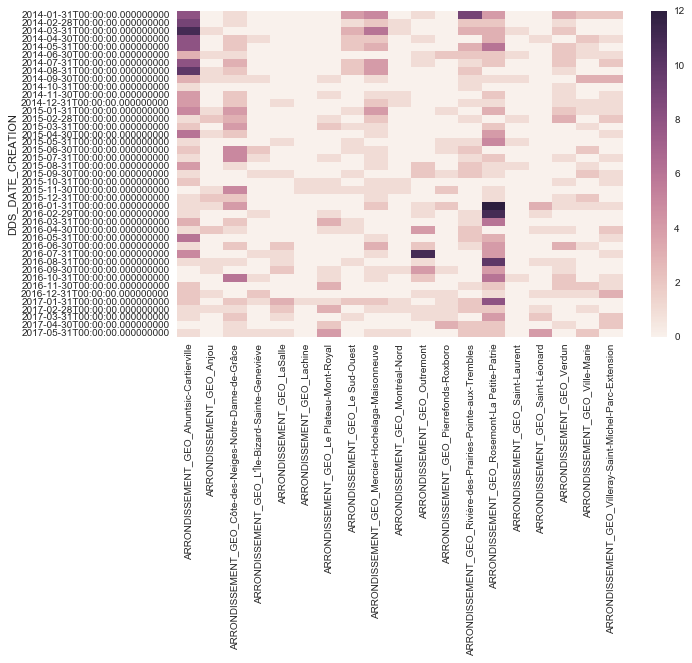

In [13]:

#JUST FOR THE HEAT MAP. ONLY TURN THIS ON IF YOU'VE SELECTED A DUMMY DF

import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 6)
sns.heatmap(CHOSEN_DATASET_HEATMAP_weekly.drop("number_of_times",1).resample("M").sum())

#from here you can see the darker problematic areas. Simple but effective. 

# Merging with weather data

In [14]:

#MERGING 311 data with weather
CHOSEN_DATASET_REGRESSION_weekly=pd.merge(CHOSEN_DATASET_REGRESSION_weekly, weather_data, left_on=[CHOSEN_DATASET_REGRESSION_weekly.index.date],right_on=[weather_data.index.date])

#getting index back as a datetimeinex, then resampling
CHOSEN_DATASET_REGRESSION_weekly.set_index(pd.DatetimeIndex(CHOSEN_DATASET_REGRESSION_weekly['key_0']),inplace=True)
CHOSEN_DATASET_REGRESSION_weekly=CHOSEN_DATASET_REGRESSION_weekly.drop("key_0",1)
CHOSEN_DATASET_REGRESSION_weekly=CHOSEN_DATASET_REGRESSION_weekly.resample("W").sum()


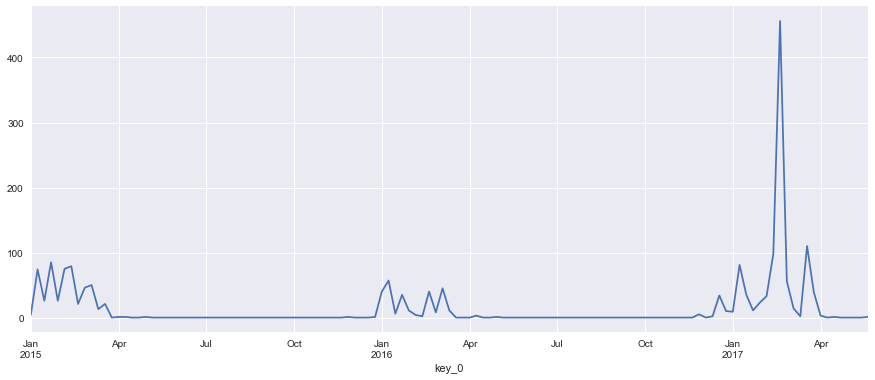

In [15]:
plt.rcParams['figure.figsize'] = (15, 6)
CHOSEN_DATASET_REGRESSION_weekly.number_of_times.plot()

In [16]:
CHOSEN_DATASET_REGRESSION_weekly["jan"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==1
CHOSEN_DATASET_REGRESSION_weekly["feb"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==2
CHOSEN_DATASET_REGRESSION_weekly["march"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==3
CHOSEN_DATASET_REGRESSION_weekly["april"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==4
CHOSEN_DATASET_REGRESSION_weekly["may"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==5
CHOSEN_DATASET_REGRESSION_weekly["june"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==6
CHOSEN_DATASET_REGRESSION_weekly["july"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==7
CHOSEN_DATASET_REGRESSION_weekly["august"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==8
CHOSEN_DATASET_REGRESSION_weekly["sept"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==9
CHOSEN_DATASET_REGRESSION_weekly["oct"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==10
CHOSEN_DATASET_REGRESSION_weekly["nov"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==11
CHOSEN_DATASET_REGRESSION_weekly["december"]=CHOSEN_DATASET_REGRESSION_weekly.index.month==12

In [17]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score

from myscripts import *

def normalize_df(df):
    #df=pd.DataFrame(df)
    df["short_term_mean"]=df.number_of_times.rolling(6).mean()
    where_outliers_be=np.abs(df.number_of_times-df.number_of_times.mean())>=(3*df.number_of_times.std())
    
    df.number_of_times[where_outliers_be]=df.short_term_mean[where_outliers_be]

    normalized_df= (df - df.mean()) / (df.max() - df.min())
    
    normalized_df=normalized_df.drop(["short_term_mean"],1)
    return normalized_df




CHOSEN_DATASET_REGRESSION_weekly=normalize_df(CHOSEN_DATASET_REGRESSION_weekly)

CHOSEN_DATASET_REGRESSION_weekly=CHOSEN_DATASET_REGRESSION_weekly.fillna(0)

c:\users\alexkeenan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
#IF YOU CHOOSE TO ADD EXTRA STATS
chosen_cols=['Max_Temp', 'Min_Temp', 'Mean_Temp', 'Total_Rain_mm','Total_Snow_cm', 'Total_Precip_mm', 'Snow_on_Grnd_cm']


def create_stats(df,window):
	#if you get infs, it's because your data was 0
	
	for each_col_name in df.columns:
		df[each_col_name].replace(to_replace=0, value=0.001, inplace=True)
		df[each_col_name+"RollingMean"]=df[each_col_name].rolling(window=window).mean()
		#df[each_col_name+"RollingStd"]=df[each_col_name].rolling(window=window).std()
		df[each_col_name+"RelAvg"]=(df[each_col_name]/df[each_col_name+"RollingMean"])-1
		#df[each_col_name+"Std"]=(df[each_col_name]-df[each_col_name+"RollingMean"])/df[each_col_name+"RollingStd"]
		df=df.drop(each_col_name,axis=1)
	df=df.ix[window-1:];
	df.fillna(0);
	return df
           
           
extra_stats=create_stats(CHOSEN_DATASET_REGRESSION_weekly[chosen_cols],5)
CHOSEN_DATASET_REGRESSION_weekly = pd.concat([CHOSEN_DATASET_REGRESSION_weekly, extra_stats],axis=1)

CHOSEN_DATASET_REGRESSION_weekly=CHOSEN_DATASET_REGRESSION_weekly.replace([np.inf, -np.inf], np.nan)
CHOSEN_DATASET_REGRESSION_weekly=CHOSEN_DATASET_REGRESSION_weekly.dropna()

c:\users\alexkeenan\appdata\local\programs\python\python35\lib\site-packages\pandas\core\generic.py:3547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
c:\users\alexkeenan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\alexkeenan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [19]:

x_cols=[]
for each in CHOSEN_DATASET_REGRESSION_weekly.columns[1:]:
    x_cols.append(each)

y_cols=[CHOSEN_DATASET_REGRESSION_weekly.columns[0]]


In [20]:
CHOSEN_DATASET_REGRESSION_weekly[x_cols] 
CHOSEN_DATASET_REGRESSION_weekly=CHOSEN_DATASET_REGRESSION_weekly.dropna()



In [21]:
CHOSEN_DATASET_REGRESSION_weekly.describe()

,number_of_times,Max_Temp,Min_Temp,Mean_Temp,Total_Rain_mm,Total_Snow_cm,Total_Precip_mm,Snow_on_Grnd_cm,Dir_of_Max_Gust,jan,...,Mean_TempRollingMean,Mean_TempRelAvg,Total_Rain_mmRollingMean,Total_Rain_mmRelAvg,Total_Snow_cmRollingMean,Total_Snow_cmRelAvg,Total_Precip_mmRollingMean,Total_Precip_mmRelAvg,Snow_on_Grnd_cmRollingMean,Snow_on_Grnd_cmRelAvg
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,...,121.000000,121.000000,121.000000,121.000000,121.000000,1.210000e+02,121.000000,121.000000,121.000000,1.210000e+02
mean,-0.010679,0.012853,0.013919,0.013682,0.003526,-0.003702,0.001493,-0.000213,0.001194,-0.029355,...,0.005965,0.181275,0.000772,-6.916660,-0.001239,-1.844261e+00,0.000096,-1.116941,0.002327,-1.107371e+00
std,0.210371,0.280164,0.271839,0.280860,0.204897,0.161724,0.203613,0.153057,0.169656,0.276489,...,0.274983,2.158824,0.100945,74.299350,0.101589,1.953704e+01,0.086619,26.801005,0.097557,1.264518e+01
min,-0.106497,-0.548730,-0.566876,-0.547760,-0.175733,-0.083413,-0.220935,-0.278823,-0.686599,-0.112000,...,-0.530543,-5.899551,-0.168589,-815.438773,-0.083413,-2.131541e+02,-0.151657,-123.352857,-0.205080,-1.045719e+02
25%,-0.106497,-0.230252,-0.191291,-0.210959,-0.150324,-0.083413,-0.135929,-0.037714,-0.099061,-0.112000,...,-0.253283,-0.393321,-0.068104,-1.552465,-0.083413,-3.169366e-01,-0.069595,-2.582907,-0.025444,-8.908470e-01
50%,-0.106497,0.003207,0.010005,-0.011533,-0.047898,-0.083413,-0.049801,0.008605,0.016793,-0.112000,...,-0.002638,-0.017578,-0.025497,-0.077305,-0.072002,-7.771561e-16,0.000508,-0.534711,0.008605,-2.220446e-15
75%,-0.051952,0.297002,0.273239,0.311638,0.049009,0.034943,0.067725,0.008605,0.130684,-0.112000,...,0.282226,0.221816,0.077875,1.313722,0.106542,4.814458e-02,0.053067,1.709075,0.008605,-1.221245e-15
max,0.893503,0.451270,0.433124,0.452240,0.824267,0.916587,0.779065,0.721177,0.313401,0.888000,...,0.419529,18.535325,0.302205,23.882406,0.236127,6.795972e+00,0.257003,226.830377,0.416883,5.627490e+01


# ELASTICNET TRAINING

In [22]:

number_of_datapoints=CHOSEN_DATASET_REGRESSION_weekly.shape[0]
train_pct=0.9
test_pct=1-train_pct
train_size=int(train_pct*number_of_datapoints)


X_train=CHOSEN_DATASET_REGRESSION_weekly[x_cols].iloc[:train_size]
y_train=CHOSEN_DATASET_REGRESSION_weekly.number_of_times.iloc[:train_size]

X_test=CHOSEN_DATASET_REGRESSION_weekly[x_cols].iloc[train_size:]
y_test=CHOSEN_DATASET_REGRESSION_weekly.number_of_times.iloc[train_size:]


In [23]:

features=X_train.columns

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
	#with scoring being blank, by default this would've outputted the accuracy, ex: 95%
	#with scoring="neg_mean_squared_error", we get accuracy -1, so shows by how much you were off and it's negative
	#then with the - in front, gives you the error, but positive. 
    return(rmse)

#ELASTIC NET METHOD
#basically combines lasso and ridge. Should usually give the best result

#this picks out the best alpha for us
model_elastic = ElasticNetCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train) #it will estimate the best alpha based on its tests with the alphas you give it

print("lowest error being %f percent"%rmse_cv(model_elastic).mean()) #we want to see the MEAN SQUARED ERROR that the best alpha provides




lowest error being 0.180673 percent


Lasso picked 21 variables and eliminated the other 13 variables


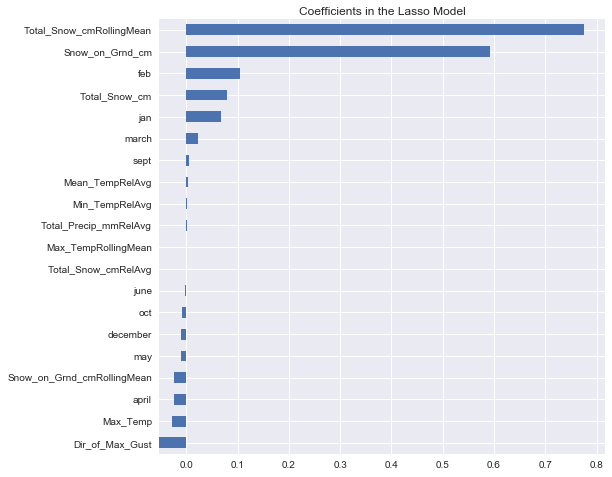

In [24]:

#FEATURE SELECTION
#getting an idea of what's important and what isn't.  
coef = pd.Series(model_elastic.coef_, index = features)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
#imp_coef = pd.concat([coef.sort_values()])

matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


mean_squared_error = 0.031


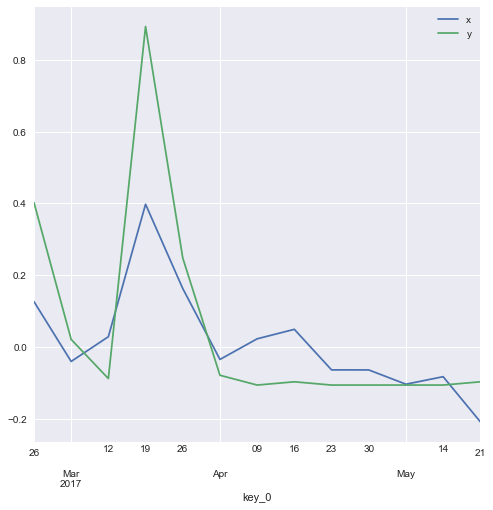

In [25]:

prediction=model_elastic.predict(X_test)

from sklearn.metrics import mean_squared_error

print("mean_squared_error = %0.3f"%mean_squared_error(prediction,y_test))

prediction=pd.DataFrame({"x":prediction,"y":y_test})
prediction.plot()

# WHERE WE COULD GO FROM HERE

We only looked at complaints, but there's a lot more in the dataset.


Could maybe have some bayesian learning, where our model keeps learning as the data comes in.

Would be nice to have a confidence interval around our expected number of complaints for a period of time. Example if you get a certain number of complaints in a short time, it should register as an anomaly. Or if there's little snow that fell, yet the number of snow removal complaints doesn't fall. These are all potential red flags.

Interpret the data as a timeseries instead of turning the months into dummy variables. Dealing with seasonality etc (I'm not too familiar with time series just yet, but would like to learn and experiment with this dataset.

Eventually put this all on a website, make it flashy and interactive. 


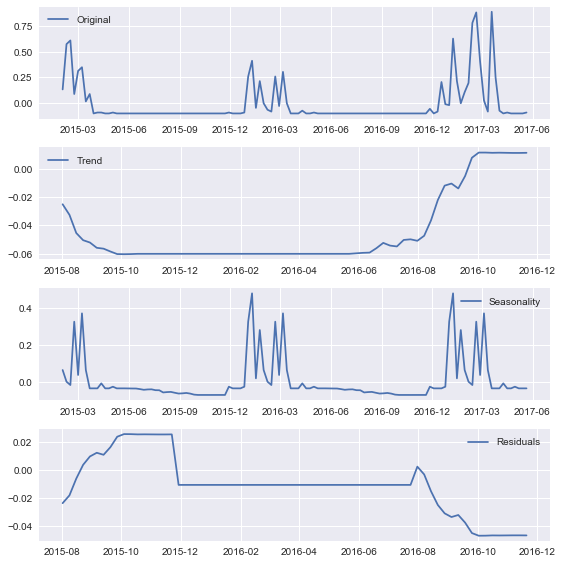

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(CHOSEN_DATASET_REGRESSION_weekly.number_of_times)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(CHOSEN_DATASET_REGRESSION_weekly.number_of_times, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()